# Clustering

Unlike regression and classification, _clustering_ is an unsupervised machine learning algorithm. The difference is in the input: supervised algorithms are given some data that has already been solved for use in training. An unsupervised algorithm has no initial training data.

The point of clustering is to find groupings of data we might not have otherwise seen. The most common practical use is in lossy compression: for example, we can greatly shrink the size of data needed to carry voice communications by clustering similar sounds.

In [17]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math

from voronoi_polygons import polygons as voronoi_polygons

np.set_printoptions(precision=4, suppress=True)

In [18]:
%matplotlib inline

The Iris dataset is a famous dataset of sepal and petal widths and lengths of three species of irises. It's used a lot for testing classification and clustering algorithms.

* https://en.wikipedia.org/wiki/Iris_flower_data_set
* https://archive.ics.uci.edu/ml/datasets/Iris

## K-Means Clustering

_K-means_ is a commonly-used clustering algorithm. It follows a simple set of steps:

1. Pick _k_ centroids, where _k_ is the number of clusters you want. The first time, pick these centroids randomly.
2. For each centroid, find all the data points closest to it. These are your clusters.
3. For each cluster, find the mean of all their points in space. Make these means your new centroids and start over.
4. Repeat until the centroids stop moving.

Below is the code we'll need to implement k-means clustering ourselves.

In [19]:
def euclidean_distance(v1, v2):
    """Finds the difference between two equally-sized 1D NumPy arrays.
    We will use this to measure the distance between points."""
    squares = (v1 - v2) ** 2
    return squares.sum() ** 0.5

In [20]:
def generate_clusters(X, centroids):
    """Given a data set X and some centroids, cluster the data points around 
    the centroids."""
    clusters = [None] * len(centroids)
    for x in X:
        # Go through the centroids, measuring the distance from the data point
        # to each centroid. Use the index of the closest centroid as the cluster
        # number.
        cluster = min([(idx, euclidean_distance(centroid, x)) 
                       for idx, centroid in enumerate(centroids)],
                        key=lambda x: x[1])[0]
        # We convert these to lists so that when we convert to a NumPy array
        # we get a multi-dimensional array, not an array of arrays.
        if clusters[cluster] is None:
            clusters[cluster] = [x.tolist()]
        else:
            clusters[cluster].append(x.tolist())
            
    return np.array(clusters)

In [30]:
def reevaluate_centroids(clusters):
    """Given some clusters, find the mean of each cluster and return it as
    a new centroid."""
    new_centroids = []
    for k in range(len(clusters)):
        new_centroids.append(np.mean(clusters[k], axis=0))
    return np.array(new_centroids)

In [31]:
def has_converged(centroids1, centroids2):
    return (set([tuple(c.tolist()) for c in centroids1]) == 
            set([tuple(c.tolist()) for c in centroids2]))

In [32]:
def kmeans(X, K):
    """Implementation of K-Means clustering using NumPy and SciKit-Learn.
    Assumes X is a 2-dimensional NumPy array."""
    
    # Get K randomly selected initial centroids.
    old_centroids = X[np.random.choice(X.shape[0], K, replace=False),:]
    centroids = X[np.random.choice(X.shape[0], K, replace=False),:]
    while not has_converged(centroids, old_centroids):
        clusters = generate_clusters(X, centroids)
        old_centroids = centroids
        centroids = reevaluate_centroids(clusters)
    return centroids, clusters

In [35]:
X = np.random.randn(50,2)

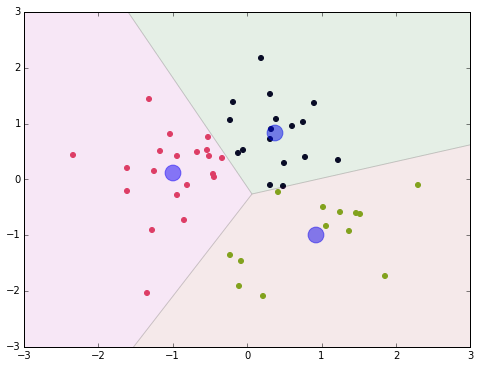

In [57]:
colors = ["#E2415F", "#7FAF1B", "#090129"]
markers = ["v", "D", "s"]
plt.figure(figsize=(8, 6))

centroids, clusters = kmeans(X, 3)
axes = plt.subplot(1,1,1)

for idx, cluster in enumerate(clusters):
    cluster = np.array(cluster)
    plt.scatter(cluster[:,0], cluster[:,1], 
                color=colors[idx], s=25, 
                marker='o')
    
plt.scatter(centroids[:, 0], centroids[:, 1],
            color="b", s=250, alpha=0.5, marker='o')
    
polys = voronoi_polygons(centroids)

for poly in polys:
    p = matplotlib.patches.Polygon(poly, facecolor=np.random.rand(3,1), alpha=0.1)
    axes.add_patch(p)

plt.show()

Try running the above several times. Note that the centroids move between runs. Why is that?

### Clustering Iris

Now that we have K-means clustering working, let's try it out with the Iris data set.

In [64]:
from sklearn.datasets import load_iris
from sklearn import preprocessing

iris = load_iris()
iris_data = iris.data
# In order for the 4-dimensional Iris data to display well in 2 dimensions, 
# we need to scale it.
print(iris.data[0:3])
iris_data = preprocessing.scale(iris.data)
print(iris_data[0:3])
centroids, clusters = kmeans(iris_data, 3)

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]]
[[-0.9007  1.0321 -1.3413 -1.313 ]
 [-1.143  -0.125  -1.3413 -1.313 ]
 [-1.3854  0.3378 -1.3981 -1.313 ]]


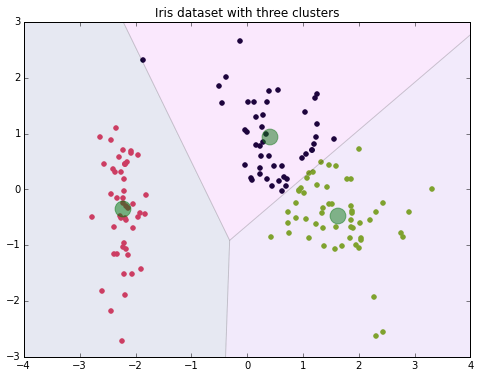

[49, 55, 46]

In [65]:
from sklearn.decomposition import PCA as PCA
pca = PCA(n_components=2).fit(iris_data)
centroids_2d = pca.transform(centroids)
colors = ["#E2415F", "#7FAF1B", "#090129"]
markers = ["v", "D", "s"]

plt.figure(figsize=(8, 6))
axes = plt.subplot(1,1,1)

for i, cluster in enumerate(clusters):
    cluster = np.array(cluster)
    cluster_2d = pca.transform(cluster)
    plt.scatter(cluster_2d[:,0], cluster_2d[:,1], color=colors[i])

plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color='g', alpha='0.5', marker='o', s=250)

polys = voronoi_polygons(centroids_2d)

for poly in polys:
    p = matplotlib.patches.Polygon(poly, facecolor=np.random.rand(3,1), alpha=0.1)
    axes.add_patch(p)
    
plt.title("Iris dataset with three clusters")
plt.show()

[len(cluster) for cluster in clusters]

Our algorithm works pretty well! You can see that it's broken the Iris data set into three clusters of 56, 50, and 44 data points. The actual data should be 50/50/50, but you can probably see in the above chart that two of the groups are hard to get perfect.

Let's try the Scikit-Learn algorithm.

In [66]:
from sklearn.cluster import KMeans

kmeans = KMeans(3)
iris_data = preprocessing.scale(iris.data)
kmeans.fit(iris_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [67]:
clusters = kmeans.predict(iris_data)
clusters.reshape((-1,50))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1,
        2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2,
        2, 2, 1, 2, 2, 1]], dtype=int32)

In [68]:
from sklearn import metrics
t = iris.target.tolist()
# t = t[50:100] + t[:50] + t[100:]
print(metrics.classification_report(t, clusters))
metrics.confusion_matrix(t, clusters)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.70      0.78      0.74        50
          2       0.75      0.66      0.70        50

avg / total       0.82      0.81      0.81       150



array([[50,  0,  0],
       [ 0, 39, 11],
       [ 0, 17, 33]])

These aren't perfect predictions either. They're split into 50/50/50, but some of the guesses are wrong compared to the actual classifications. Using the Voronoi diagram below, you can see where we split vs the actual classification.

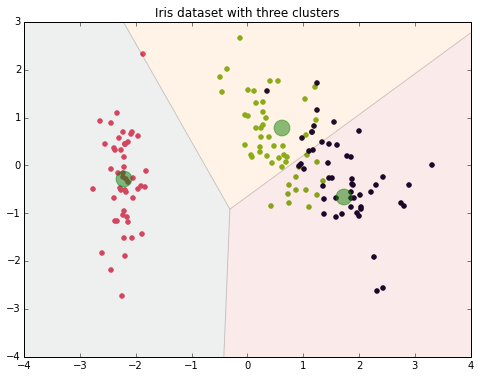

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(iris_data)
pca_2d = pca.transform(iris_data)

cluster_2d = pca.transform(kmeans.cluster_centers_)
colors = ["#E2415F", "#7FAF1B", "#090129"]
markers = ["v", "D", "s"]

plt.figure(figsize=(8, 6))
axes = plt.subplot(1,1,1)

for i in range(pca_2d.shape[0]):
    c = clusters[i]
    color = colors[iris.target[i]]
    plt.scatter(pca_2d[i,0], pca_2d[i, 1], color=color)
    
for i in range(cluster_2d.shape[0]):
    plt.scatter(cluster_2d[i, 0], cluster_2d[i, 1], color='g', alpha='0.5', s=250, marker='o')

plt.title("Iris dataset with three clusters")

polys = voronoi_polygons(centroids_2d)

for poly in polys:
    p = matplotlib.patches.Polygon(poly, facecolor=np.random.rand(3,1), alpha=0.1)
    axes.add_patch(p)
    
plt.show()
        

In [81]:
from sklearn.cluster import MeanShift

ms = MeanShift(bandwidth=1.25)
iris_data = preprocessing.scale(iris.data)
ms.fit(iris_data)
clusters = ms.predict(iris_data)
clusters.reshape((-1,50))

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0]])

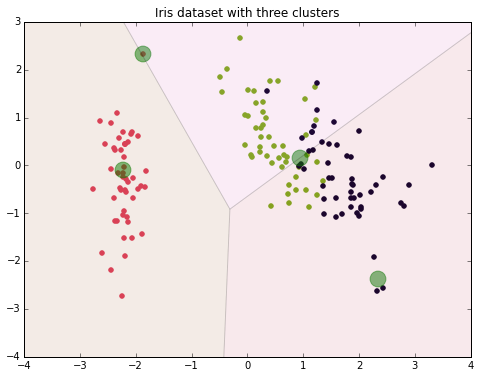

In [82]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(iris_data)
pca_2d = pca.transform(iris_data)

cluster_2d = pca.transform(ms.cluster_centers_)
colors = ["#E2415F", "#7FAF1B", "#090129"]

plt.figure(figsize=(8, 6))
axes = plt.subplot(1,1,1)

for i in range(pca_2d.shape[0]):
    c = clusters[i]
    color = colors[iris.target[i]]
    plt.scatter(pca_2d[i,0], pca_2d[i, 1], color=color)
    
for i in range(cluster_2d.shape[0]):
    plt.scatter(cluster_2d[i, 0], cluster_2d[i, 1], color='g', alpha='0.5', s=250, marker='o')

plt.title("Iris dataset with three clusters")

polys = voronoi_polygons(centroids_2d)

for poly in polys:
    p = matplotlib.patches.Polygon(poly, facecolor=np.random.rand(3,1), alpha=0.1)
    axes.add_patch(p)
    
plt.show()
        

## Exercise

Reduce image to 16 colors using clustering.

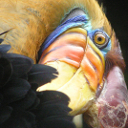

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import Image as IPythonImage

im = Image.open("bird_small.jpg")
IPythonImage('bird_small.jpg')

In [33]:
print(np.asarray(im)[:3,:3])

[[[219 180 103]
  [230 185 117]
  [225 186 109]]

 [[232 192 120]
  [224 191 120]
  [226 191 123]]

 [[228 191 123]
  [228 191 120]
  [220 185 119]]]


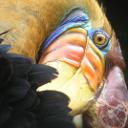

In [34]:
import scipy
scipy.misc.imsave('bird_small_resample.jpg', im)
IPythonImage('bird_small_resample.jpg')